# Bitcoins prediction using Deep Learning: RNN (Recurrent Neural Network) 
***(©2021 Fred Bone All rights reserved)***

The purpose of this analysis is on the one hand to find the best month to buy or sell bitcoins and on the other hand to predict the type of trend of the bitcoins in the following month using data of the past few years.

Credits for the nice explanatory pictures of RNN go to the ones mentioned at the bottom of these pictures.

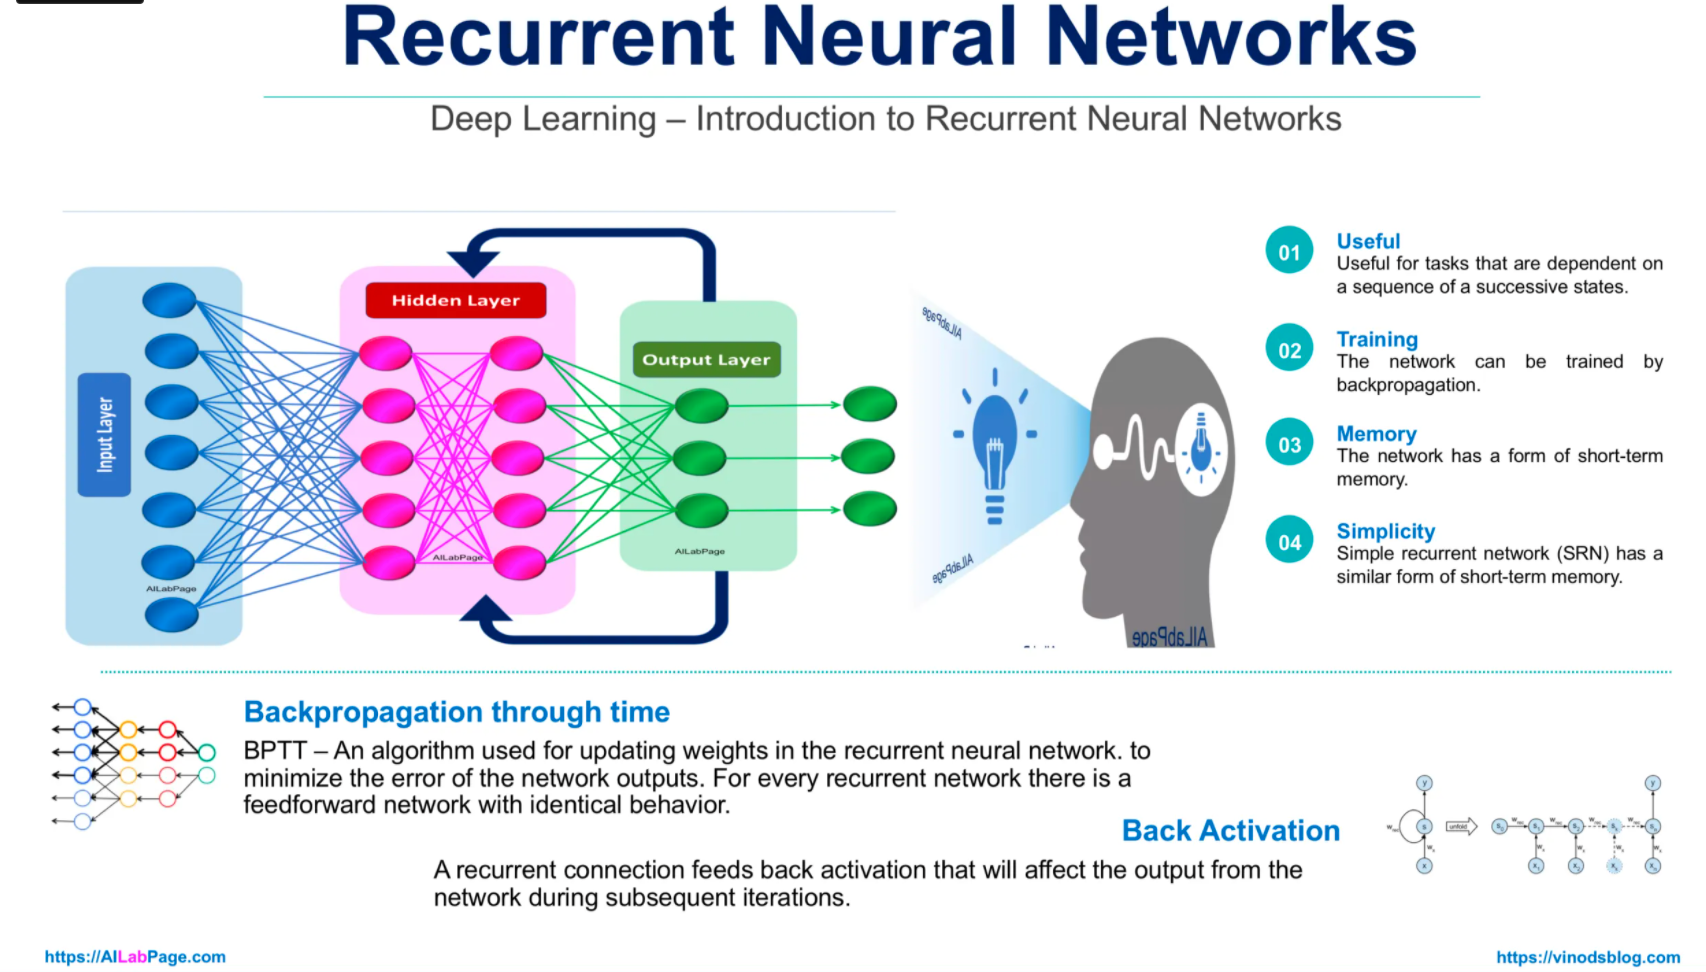


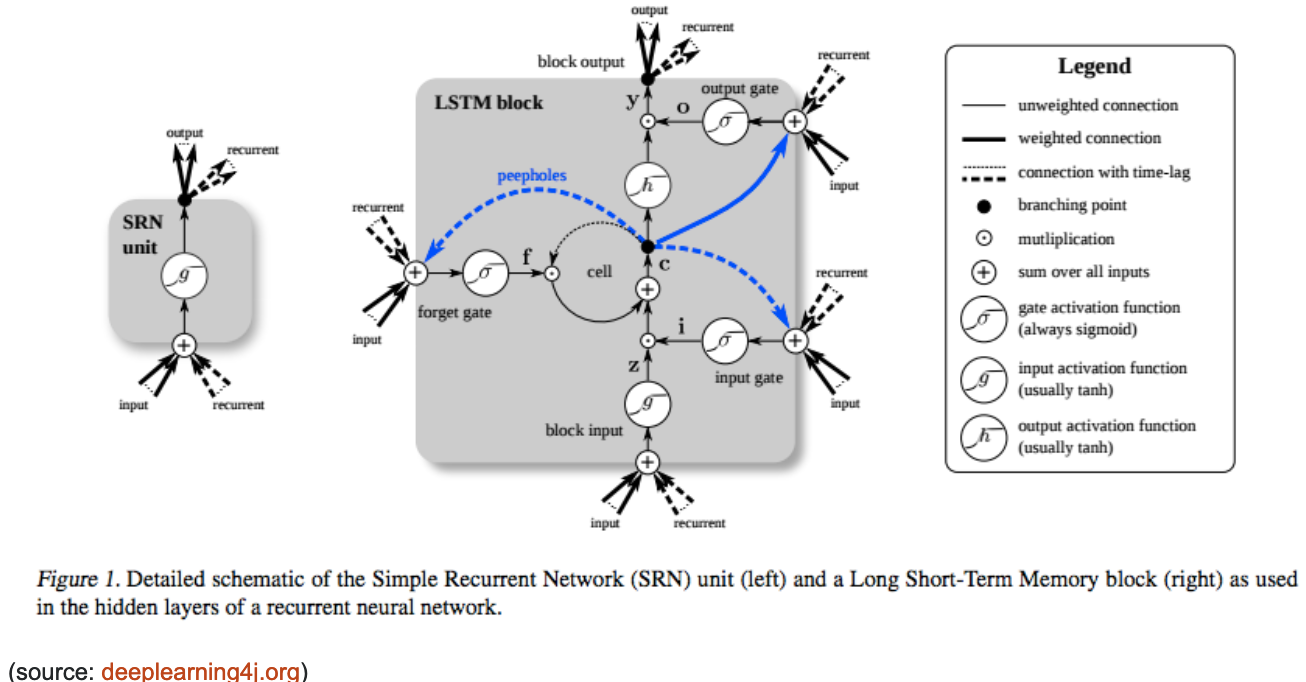

## 1 - Loding the Data 

In [ ]:

# Importing the libraries

# To load the data
import pandas as pd

# For numeric and mathematical operations
import numpy as np
import math

# To visualise the data
import matplotlib.pyplot as plt

# To preprocess the data
from sklearn.preprocessing import MinMaxScaler

# Importing the Keras libraries to build the RNN model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# To save the scaler
import joblib

# To save the model
from keras.models import load_model


In [ ]:
# Importing the training set

url = 'https://raw.githubusercontent.com/fredboneML/Bitcoin-Analysis/main/BTC-EUR.csv'
bitcoin = pd.read_csv(url, index_col='Date', parse_dates=True)
bitcoin.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,359.546204,361.468506,351.586884,355.957367,355.957367,16389165
2014-09-18,355.588409,355.505402,319.789459,328.539368,328.539368,26691849
2014-09-19,328.278503,330.936707,298.921021,307.761139,307.761139,29560102
2014-09-20,307.665253,329.978180,303.931244,318.758972,318.758972,28736825
2014-09-21,318.120514,321.504517,306.502197,310.632446,310.632446,20702624


# 2 - Explorative Data Analysis

### Bitcoin evolution since 2014

Text(0.5, 1.0, 'Bitcoin evolution from 2014-09-17 00:00:00 to 2021-01-07 00:00:00')

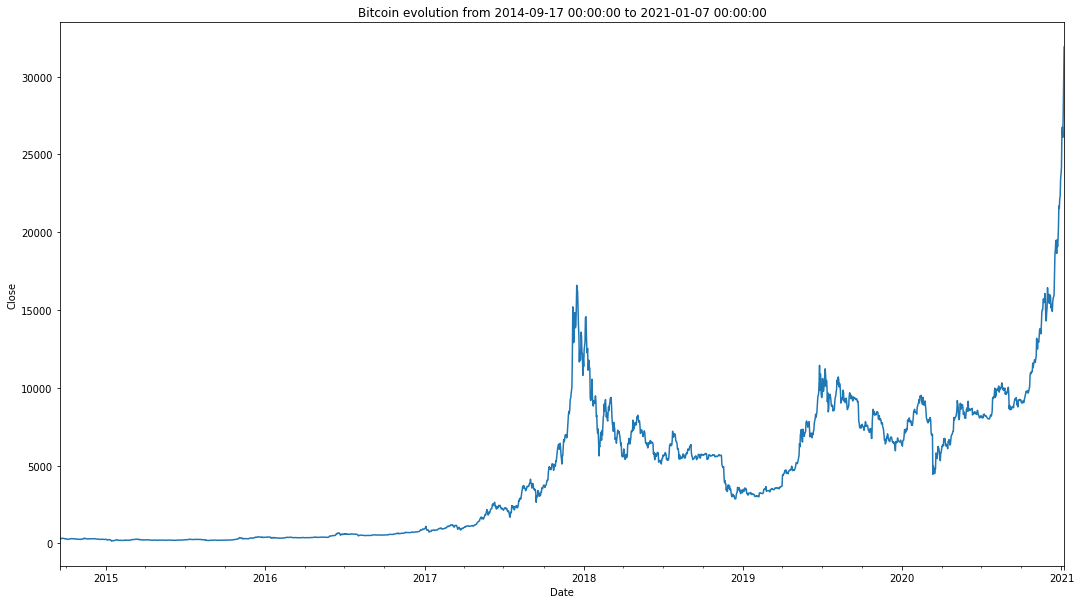

In [ ]:
plt.figure(figsize=(18,10))
bitcoin['Close'].plot()
plt.xlabel('Date')
plt.ylabel('Close')
plt.title(f'Bitcoin evolution from {min(bitcoin.index)} to {max(bitcoin.index)}')

### Let's zoom in in each year

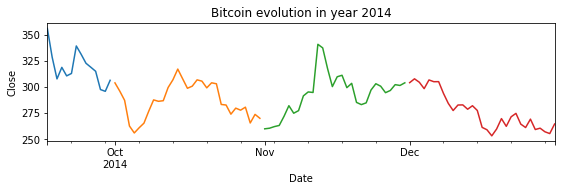

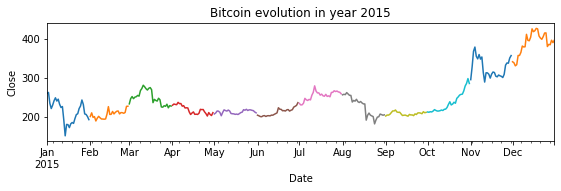

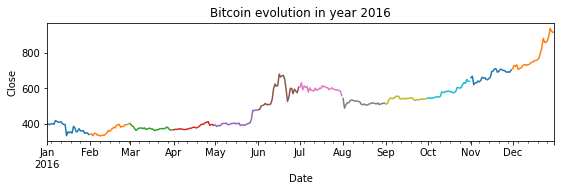

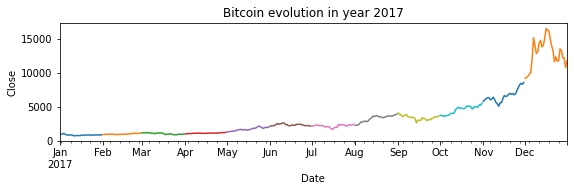

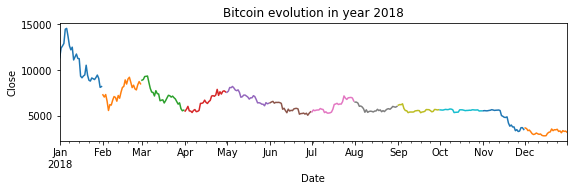

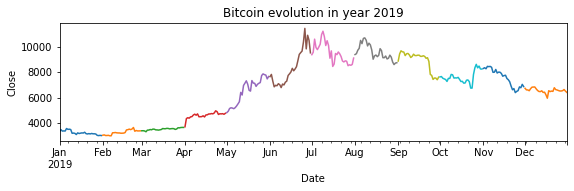

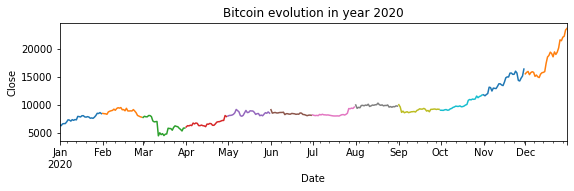

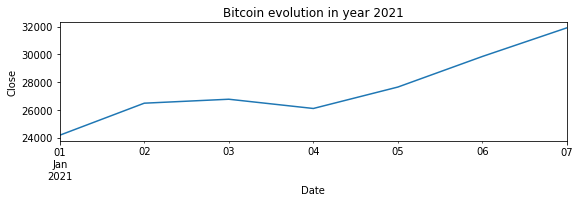

In [ ]:


min_year = min(bitcoin.index).year
max_year = max(bitcoin.index).year
j = 0
for i in range(min_year, max_year + 1, 1):
  plt.figure(figsize=(20,10))
  plt.subplot(math.ceil((max_year - min_year + 1) / 2), 2, j + 1 )
  j += 1
  bitcoin.loc[str(i), 'Close'].resample('M').plot()
  plt.xlabel('Date')
  plt.ylabel('Close')
  plt.title(f'Bitcoin evolution in year {i}')
  plt.show()
 


Zooming in each year shows that except in the year 2014 and 2018,  there is an **increasing trend from September to December (December having the highest values)** and in contrast a **decreasing trend from January to May (February having the least value)**. Base on these first visualisations, we could say that ***the best month to buy bitcoins is in February and to sell in December.*** 

# 3 - Data Preprocessing

We will try to predict the below Close values of December 2020 and biginning of January 2021 using data from 2014 up to November 2020.

In [ ]:
bitcoin.loc['2020-12-01':, 'Close']

Date
2020-12-01    15576.629883
2020-12-02    15850.040039
2020-12-03    16010.777344
2020-12-04    15428.222656
2020-12-05    15799.846680
2020-12-06    15961.175781
2020-12-07    15847.105469
2020-12-08    15129.400391
2020-12-09    15361.175781
2020-12-10    15040.947266
2020-12-11    14910.423828
2020-12-12    15525.333008
2020-12-13    15776.826172
2020-12-14    15842.547852
2020-12-15    15975.224609
2020-12-16    17473.498047
2020-12-17    18598.726563
2020-12-18    18877.660156
2020-12-19    19473.654297
2020-12-20    19224.947266
2020-12-21    18637.574219
2020-12-22    19514.736328
2020-12-23    19059.505859
2020-12-24    19481.566406
2020-12-25    20230.060547
2020-12-26    21683.658203
2020-12-27    21527.597656
2020-12-28    22161.601563
2020-12-29    22330.292969
2020-12-30    23450.607422
2020-12-31    23741.736328
2021-01-01    24165.556641
2021-01-02    26474.892578
2021-01-03    26760.720703
2021-01-04    26094.005859
2021-01-05    27639.482422
2021-01-06    29844.859

In [ ]:
dataset_test = bitcoin.loc['2020-12-01':, 'Close'].values
training_set = bitcoin.loc[:'2020-12-01', 'Close'].values
print(f' We have {dataset_test.shape[0]} observations in the test set and {training_set.shape[0]} observations in the training set.')

 We have 38 observations in the test set and 2268 observations in the training set.


In [ ]:
# For the moment the training set is a 1D array
training_set.shape

(2268,)

In [ ]:
# Reshaping the training set to be a 2D instead of 1D array
training_set = training_set.reshape(-1, 1)
# Checking the shape again
training_set.shape

(2268, 1)

In [ ]:

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, training_set.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))




# 4 - Building the Recurrent Neural Network (RNN)

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
69/69 [==============================] - 13s 95ms/step - loss: 0.0247
Epoch 2/100
69/69 [==============================] - 6s 90ms/step - loss: 0.0042
Epoch 3/100
69/69 [==============================] - 6s 93ms/step - loss: 0.0036
Epoch 4/100
69/69 [==============================] - 7s 97ms/step - loss: 0.0033
Epoch 5/100
69/69 [==============================] - 7s 102ms/step - loss: 0.0025
Epoch 6/100
69/69 [==============================] - 7s 103ms/step - loss: 0.0029
Epoch 7/100
69/69 [==============================] - 6s 94ms/step - loss: 0.0023
Epoch 8/100
69/69 [==============================] - 6s 94ms/step - loss: 0.0027
Epoch 9/100
69/69 [==============================] - 6s 94ms/step - loss: 0.0020
Epoch 10/100
69/69 [==============================] - 7s 96ms/step - loss: 0.0021
Epoch 11/100
69/69 [==============================] - 7s 100ms/step - loss: 0.0020
Epoch 12/100
69/69 [==============================] - 7s 97ms/step - loss: 0.0024
Epoch 13/100
69/69 [=

In [ ]:
# Saving the RNN model and the scaler
   
# ----------- Saving the RNN model -----------
# Creating a HDF5 file 'RNN_Model_Bitcoin.h5'
regressor.save('RNN_Model_Bitcoin.h5')  
# To load the model later
# regressor = load_model('RNN_Model_Bitcoin.h5')

#------------- Saving the scaler ---------------
scaler_filename = 'MinMaxScaler_RNN_Model_Bitcoin.gz'
joblib.dump(sc, scaler_filename) 

# To load the scaler later
# sc = joblib.load('MinMaxScaler_RNN_Model_Bitcoin.gz')  


['MinMaxScaler_RNN_Model_Bitcoin.gz']

# 5 - Making the predictions

In [ ]:
# Getting the real bitcoin price from 1st of December 2021 onwards 
real_bitcoin_price = bitcoin.loc['2020-12-01':, 'Close'].values

# Getting the predicted bitcoins price from 1st of December 2021 onwards 
dataset_total = pd.concat((bitcoin.loc[:'2020-12-01', 'Close'], bitcoin.loc['2020-12-01':, 'Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 60 + dataset_test.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_bitcoin_price = regressor.predict(X_test)
predicted_bitcoin_price = sc.inverse_transform(predicted_bitcoin_price)


# 6 - Visualising the results

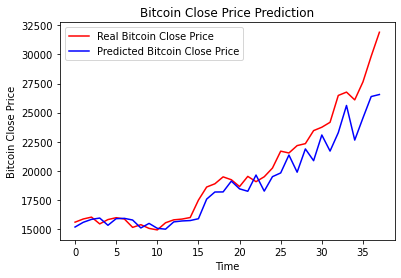

In [ ]:
plt.plot(real_bitcoin_price, color = 'red', label = 'Real Bitcoin Close Price')
plt.plot(predicted_bitcoin_price, color = 'blue', label = 'Predicted Bitcoin Close Price')
plt.title('Bitcoin Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Close Price')
plt.legend()
plt.show()

# Conclusion


*   We saw that December is the best month to sell Bitcoins and February (and perhaps March) the best one to buy.
*   We also trained a powerfull Deep Learning AI model (Recurrent Neural Network) that is able to predict the trend of the Bitcoin.

